In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry
import feature_extraction as fe

In [3]:
ee.Authenticate()
ee.Initialize()

In [4]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B2', 'B3', 'B4']

In [5]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [6]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2020-01-01', '2021-01-30')
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
    .map(mask_s2_clouds)
)

In [7]:
geometry_sd = ee.Geometry.Polygon(
    [[[-70.08239177868184,18.412691062890588],
      [-69.70542339489278,18.412691062890588],
      [-69.70542339489278,18.610630760258402],
      [-70.08239177868184,18.610630760258402]]])

sd_cutout = dataset.median().clip(geometry_sd).select(FEATURES)

In [8]:
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.set_center(-69.929611, 18.483402, 12)
m.add_layer(sd_cutout, visualization, 'RGB')
m

Map(center=[18.483402, -69.929611], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

In [9]:
# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_files = []

output_path = os.path.join(temp_dir, "santo_domingo_img_0.tif")
if not os.path.exists(output_path):
    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_sd, num_parts=3)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"santo_domingo_img_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(sd_cutout, filename=output_filename, region=geojson_geometry, scale=1)
        print(f"Exporting {output_filename}...")

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"santo_domingo_img_{i}.tif") for i in range(len(subgeometries))]
else:
    print("Found existing santo_domingo_img_#.tif file. Using that instead.")

Found existing santo_domingo_img_#.tif file. Using that instead.


In [10]:
output_files

[]

In [22]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16 as vgg
from keras.applications.vgg16 import preprocess_input as vgg_p

In [11]:
print(os.path.join(temp_dir, "santo_domingo_img_0.tif"))

temporary\santo_domingo_img_0.tif


In [35]:
output_files = ['temporary\santo_domingo_img_0.tif',
 'temporary\santo_domingo_img_1.tif',
 'temporary\santo_domingo_img_2.tif',
 'temporary\santo_domingo_img_3.tif',
 'temporary\santo_domingo_img_4.tif',
 'temporary\santo_domingo_img_5.tif',
 'temporary\santo_domingo_img_6.tif',
 'temporary\santo_domingo_img_7.tif',
 'temporary\santo_domingo_img_8.tif']

In [14]:
from tensorflow.keras.preprocessing import image

# Specify the path to your TIFF image
image_path = 'santo_domingo_img_8.tif'

try:
    # Load the image using Keras
    img = image.load_img(image_path, target_size=None)
    img.show()  # This will display the image if everything is correct
except Exception as e:
    print(f'Error loading image: {e}')

with open(image_path, 'rb') as f:
    content = f.read()
    print(content[:20])  # Print first 20 bytes to check the file signature

Error loading image: cannot identify image file <_io.BytesIO object at 0x0000027B291AA110>
b'MM\x00*\x00\x00\x00\x08\x00\x10\x01\x00\x00\x03\x00\x00\x00\x01\x05x'


In [15]:
from PIL import Image

image_path = 'santo_domingo_img_8.tif'
image_path = os.path.join(os.getcwd(), image_path)

try:
    img = Image.open(image_path)
    img.show()  # This should display the image
except Exception as e:
    print(f'Error loading image with Pillow: {e}')

Error loading image with Pillow: cannot identify image file 'C:\\Users\\juane\\Desktop\\MSc Urban Spatial Science\\Term 3\\Dissertation\\TemporalClusterNet\\santo_domingo_img_8.tif'


In [17]:
median_image_raster = rasterio.open('santo_domingo_img_8.tif')

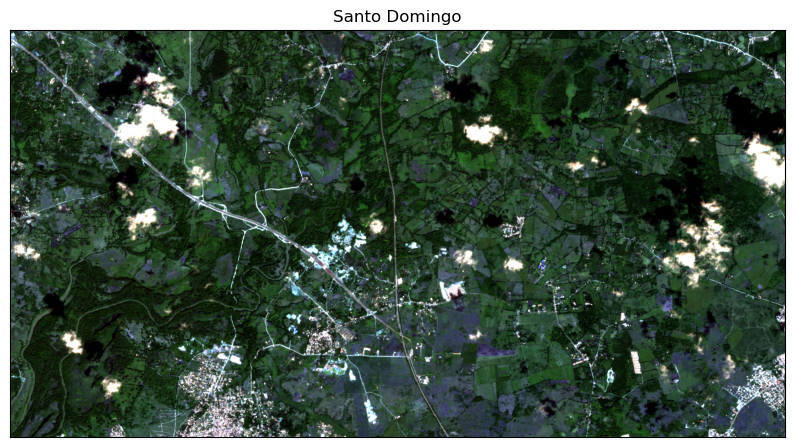

In [19]:
# Plot median_image_raster
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ep.plot_rgb(median_image_raster.read([1, 2, 3]), ax=ax, title="Santo Domingo", stretch=True)
plt.show()

In [31]:
output_files = ['santo_domingo_img_8.tif']

In [24]:
from rasterio.plot import reshape_as_raster, reshape_as_image

In [37]:
image_list = []
for img_path in output_files:
    with rasterio.open(img_path) as src:
        img = src.read([1, 2, 3])  # Read the first three channels (RGB)
        img = np.transpose(img, (1, 2, 0))  # Transpose to (height, width, channels)
        img = image.array_to_img(img, scale=False)
        img = img.resize((736, 1400))  # Resize the image to the desired size
        image_list.append(img)
    
df_features = fe.extract(vgg, vgg_p, image_list, (1400, 736, 3))

print(df_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 72s 72s/step
        0         1         2          3        4          5         6     \
0  18.213236  4.808353  9.204552  27.896444  6.85533  84.686577  1.467097   
1  18.213236  4.808353  9.204552  27.896444  6.85533  84.686577  1.467097   
2  18.213236  4.808353  9.204552  27.896444  6.85533  84.686577  1.467097   
3  18.213236  4.808353  9.204552  27.896444  6.85533  84.686577  1.467097   
4  18.213236  4.808353  9.204552  27.896444  6.85533  84.686577  1.467097   
5  18.213236  4.808353  9.204552  27.896444  6.85533  84.686577  1.467097   
6  18.213236  4.808353  9.204552  27.896444  6.85533  84.686577  1.467097   
7  18.213236  4.808353  9.204552  27.896444  6.85533  84.686577  1.467097   
8  18.213236  4.808353  9.204552  27.896444  6.85533  84.686577  1.467097   

       7         8          9     ...      5855      5856      5857      5858  \
0  5.216623  12.23634  10.502387  ...  1.137919  3.229071  8.269510  0.531811   
1  5.216623  12.23634  10.502

In [38]:
df_features

,0,1,2,3,4,5,6,7,8,9,...,5855,5856,5857,5858,5859,5860,5861,5862,5863,5864
0,18.213236,4.808353,9.204552,27.896444,6.85533,84.686577,1.467097,5.216623,12.23634,10.502387,...,1.137919,3.229071,8.269510,0.531811,1.552672,4.483919,0.229822,26.776646,0.702096,14.836510
1,18.213236,4.808353,9.204552,27.896444,6.85533,84.686577,1.467097,5.216623,12.23634,10.502387,...,1.137919,3.229071,8.269510,0.531811,1.552672,4.483919,0.229822,26.776646,0.702096,14.836510
2,18.213236,4.808353,9.204552,27.896444,6.85533,84.686577,1.467097,5.216623,12.23634,10.502387,...,1.137919,3.229071,8.269510,0.531811,1.552672,4.483919,0.229822,26.776646,0.702096,14.836510
3,18.213236,4.808353,9.204552,27.896444,6.85533,84.686577,1.467097,5.216623,12.23634,10.502387,...,1.137919,3.229071,8.269510,0.531811,1.552672,4.483919,0.229822,26.776646,0.702096,14.836510
4,18.213236,4.808353,9.204552,27.896444,6.85533,84.686577,1.467097,5.216623,12.23634,10.502387,...,1.137919,3.229071,8.269510,0.531811,1.552672,4.483919,0.229822,26.776646,0.702096,14.836510
5,18.213236,4.808353,9.204552,27.896444,6.85533,84.686577,1.467097,5.216623,12.23634,10.502387,...,1.137920,3.229068,8.269550,0.531811,1.552672,4.483919,0.229822,26.776646,0.702096,14.836510
6,18.213236,4.808353,9.204552,27.896444,6.85533,84.686577,1.467097,5.216623,12.23634,10.502387,...,1.137919,3.229071,8.269510,0.531811,1.552672,4.483919,0.229822,26.776646,0.702096,14.836510
7,18.213236,4.808353,9.204552,27.896444,6.85533,84.686577,1.467097,5.216623,12.23634,10.502387,...,1.137324,3.229770,8.266794,0.530830,1.555814,4.480849,0.230290,26.777802,0.702976,14.835701
8,18.213236,4.808353,9.204552,27.896444,6.85533,84.686577,1.467097,5.216623,12.23634,10.502387,...,1.137919,3.229071,8.269510,0.531811,1.552672,4.483919,0.229822,26.776646,0.702096,14.836510


In [44]:
# For all the rows, check to see if they are identical to other rows
df_features.duplicated(keep=False)


0     True
1     True
2     True
3    False
4     True
5    False
6    False
7    False
8    False
dtype: bool

In [51]:
# print differences between row 5 and row 6
print((df_features.iloc[5] - df_features.iloc[6]).where(lambda x : x != 0.0).dropna())




37     -5.698204e-05
38     -2.670288e-05
42     -4.577637e-05
44      1.726151e-04
45      3.051758e-05
            ...     
5853    9.536743e-07
5854   -1.907349e-06
5855    9.536743e-07
5856   -2.384186e-06
5857    4.005432e-05
Length: 589, dtype: float32
